In [1]:
import pandas as pd
import numpy as np
from data_generator.batch_generator import BatchGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint#, TensorBoard
import pickle
from models import AlexNet, LeNet
from keras import backend as K
import glob
%matplotlib inline
K.set_image_data_format('channels_last')

Using TensorFlow backend.


### ATENÇÃO: SELECIONAR OS PATHS PROS PESOS

In [2]:
activations = ['relu', 'lrelu']
#img_treats=['image-treat-1', 'image-treat-2', 'image-treat-3']
img_treats=['abordagem-4', 'abordagem-5']
#nets = ['lenet', 'alexnet']
nets = ['lenet']

activation, img_treat, net = activations[0], img_treats[1], nets[0]
activation, img_treat, net

('relu', 'abordagem-5', 'lenet')

In [3]:
test_dataset = BatchGenerator(box_output_format=['class_id'])
test_dataset.parse_csv(labels_filename='/home/nicoli/github/alexnet/dataset/csv/imdb_csv/imdb_age_regression_test_split_47950-70-10-20.csv', 
                        images_dir='/home/nicoli/github/alexnet/dataset/imdb-hand-crop/',
                        input_format=['image_name', 'class_id'])

In [4]:
print("Number of images in the dataset:", test_dataset.get_n_samples())

Number of images in the dataset: 9590


In [5]:
img_height, img_width, img_depth = (224,224,3)

#epochs = 90

batch_size=100
shuffle = True
ssd_train = False

#validation_batch_size = 10
#batch_size = validation_batch_size

# In[15]:

test_generator = test_dataset.generate(batch_size=batch_size,
                                       shuffle=shuffle,
                                       ssd_train=ssd_train,
                                       #flip=0.5,
                                       #equalize=True,
                                       divide_by_stddev=255,
                                       returns={'processed_labels'},
                                       resize=(img_height, img_width))

In [6]:
steps = test_dataset.get_n_samples()

In [7]:
net

'lenet'

In [8]:
if net == 'alexnet':
    net_obj = AlexNet
elif net == 'lenet':
    net_obj = LeNet
weights_path = glob.glob('callbacks/' + net + '/age/consolidados/class-weights-' + img_treat + '-' + activation + '*')[0]
#weights_path = glob.glob('callbacks/' + net + '/age/class-weights-' + img_treat + '-' + activation + '.' + melhor_epoca + '*')[0]
model = net_obj(1, img_width, img_height, img_depth, activation, weights_path=weights_path)


# In[7]:


model.summary()
#alexnet.model.load_weights('callbacks/alexnet/age/weights.24-1658.03.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 220, 220, 6)       456       
_________________________________________________________________
activation_1 (Activation)    (None, 220, 220, 6)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 6)       0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 106, 106, 16)      2416      
_________________________________________________________________
activation_2 (Activation)    (None, 106, 106, 16)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 53, 53, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 44944)             0         
__________

/home/nicoli/github/alexnet/models.py:109: UserWarning: Considering a regression task with output function being relu
  warnings.warn(warning)


In [9]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0000000001, amsgrad=True)

In [10]:
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

In [11]:
prev = next(test_generator)


#prev[1]

In [12]:
predict = model.predict(prev[0])

print(predict[:4])

[[37.66062 ]
 [31.705462]
 [37.47867 ]
 [44.8093  ]]


[3] [28.68852]


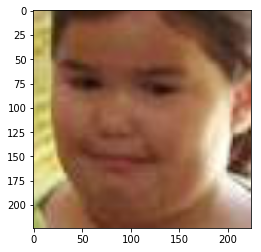

In [13]:
i=4
print(prev[1][i], predict[i])
import matplotlib.pyplot as plt
plt.imshow(prev[0][i])

In [14]:
x =  [i for i in range(batch_size)]

In [15]:
len(x)

100

In [16]:
import pandas as pd
df_results = pd.DataFrame({
    'Ŷ Previsto': prev[1].reshape(batch_size),
    'Y Real': list(predict.reshape(batch_size))#,
    #'Item': [i for i in range(1,batch_size+1)]
}, index=[i for i in range(batch_size)])

In [17]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("", ["0.5","0.1"])
cmap_rev = LinearSegmentedColormap.from_list("", ["0.1","0.5"])

In [18]:
df_results['Ŷ Previsto'] = df_results['Ŷ Previsto'] - df_results['Y Real']

df_results['Y Real']=0

In [19]:
df_results.rename({'Ŷ Previsto': 'Ŷ Previsto - Y Real', 'Y Real': 'Zero'}, inplace=True, axis=1)

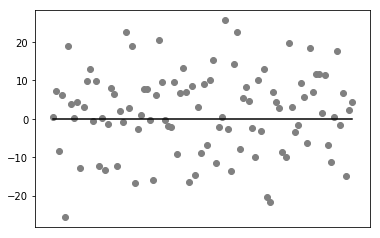

In [20]:
fig = df_results.plot(y='Zero', color='black')
fig.axes.scatter(x=df_results.index, y=df_results['Ŷ Previsto - Y Real'],color='grey')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_legend().set_visible(False)

In [21]:
fig.get_figure().savefig('graficos/result-reta/fig-reta-0-' + img_treat + '-'+ net +'-'+ activation +'.png')